In [17]:
from __future__ import division
import cProfile
import ctypes
import cv2
import h5py
from IPython.display import clear_output
from IPython.display import Image
from IPython.display import display
import json
import math
from matplotlib import pyplot as plt
import numpy as np
import PIL.Image
from pprint import pprint
import os
import requests
from scipy import stats
from sklearn.preprocessing import StandardScaler
import sys
from timeit import default_timer as timer
from types import NoneType
import random

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

# Image feature extractor

In [18]:
import wand.image
from wand.api import library

class WandExtender(wand.image.Image):
    class __ChannelStatistics(ctypes.Structure):
        _fields_ = [('depth', ctypes.c_size_t),
                    ('minima', ctypes.c_double),
                    ('maxima', ctypes.c_double),
                    ('sum', ctypes.c_double),
                    ('sum_squared', ctypes.c_double),
                    ('sum_cubed', ctypes.c_double),
                    ('sum_fourth_power', ctypes.c_double),
                    ('mean', ctypes.c_double),
                    ('variance', ctypes.c_double),
                    ('standard_deviation', ctypes.c_double),
                    ('kurtosis', ctypes.c_double),
                    ('skewness', ctypes.c_double),
                    ('entropy', ctypes.c_double)]

    def __init__(self, *args, **kwargs):
        super(WandExtender, self).__init__(*args, **kwargs)
        library.MagickGetImageChannelStatistics.argtypes = [ctypes.c_void_p]
        library.MagickGetImageChannelStatistics.restype = \
            ctypes.POINTER(self.__ChannelStatistics)
        library.MagickGetImageColors.argtypes = [ctypes.c_void_p]
        library.MagickGetImageColors.restype = ctypes.c_size_t

    def channelStats(self, channel=0x002F, name="FS", qrange=65535):
        s = library.MagickGetImageChannelStatistics(self.wand)
        channDict = {}
        for p in dir(s[channel]):
            if p[0] == '_': continue
            val = getattr(s[channel], p)
            if p in ['maxima', 'minima', 'mean', 'standard_deviation', 'sum']:
                channDict[name + "_" + p] = val / qrange
            elif p in ['sum_squared', 'variance']:
                channDict[name + "_" + p] = val / (qrange ** 2)
            elif p == 'sum_cubed':
                channDict[name + "_" + p] = val / (qrange ** 3)
            elif p == 'sum_fourth_power':
                channDict[name + "_" + p] = val / (qrange ** 4)
            else:
                channDict[name + "_" + p] = val
        f32max = np.finfo(np.float32).max
        f32min = np.finfo(np.float32).min
        for k, v in channDict.items():
            if v > f32max or v < f32min:
                channDict[k] = 0.0
        return channDict

    def getColorCnt(self):
        c = library.MagickGetImageColors(self.wand)
        return {"FS_colorCnt": c}


class ImgAnalyzer:
    def __init__(self, path, img, display=False):
        self.path = path
        self.pil_img = img
        self.np_img = np.asarray(self.pil_img)
        self.wand_img = wand.image.Image(filename=path)
        self.wandE_img = WandExtender(self.wand_img)

        self.pil_bpp = {'1': 1, 'L': 8, 'P': 8, 'RGB': 24, 'RGBA': 32,
                        'CMYK': 32, 'YCbCr': 24, 'LAB': 24, 'HSV': 24,
                        'I': 32, 'F': 32}
        # self.make_cv2_img()
        self.cv2_img = cv2.imread(path, -1)
        self.gray_img = cv2.imread(path, 0)
        if self.getChannelsDim() == 4:
            self.cv2_rbg_img = cv2.imread(path, 1)
        # self.make_cv2_grey_img()
        self.properties = {}
        if display:
            cv2.namedWindow('image', cv2.WINDOW_NORMAL)
            cv2.imshow('image', self.cv2_img)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    def make_cv2_img(self):
        cv2modes = set([str(i).split("COLOR_")[1].split("2")[0]
                        for i in dir(cv2) if i.startswith('COLOR_')])
        chanDim = self.getChannelsDim()
        mode = self.getMode()
        if chanDim == 4 and mode in cv2modes:
            # vythout alpha
            c2c = "COLOR_" + mode + "2BGR"
            self.cv2_rbg_img = cv2.cvtColor(self.np_img, getattr(cv2, c2c))
            c2c = "COLOR_" + mode + "2BGRA"
        elif chanDim == 3 and mode in cv2modes:
            c2c = "COLOR_" + mode + "2BGR"
        else:
            c2c = "COLOR_" + "GRAY" + "2BGRA"
        cv2modes = set([str(i)
                        for i in dir(cv2) if i.startswith('COLOR_')])
        if c2c:
            self.cv2_img = cv2.cvtColor(self.np_img, getattr(cv2, c2c))

    def make_cv2_grey_img(self):
        self.gray_img = cv2.cvtColor(self.cv2_img, cv2.COLOR_BGR2GRAY)
        return self.gray_img

    def getProperties(self):
        tp = {}
        # tp["sizeX"], tp["sizeY"] = self.getSize()
        tp["dpiX"], tp["dpiY"] = None, None
        dpi = self.getDPI()
        if dpi:
            tp["dpiX"], tp["dpiY"] = dpi[0], dpi[1]
        tp["frames"] = self.getFrames()
        tp["format"] = self.getFormat()
        tp["mode"] = self.getMode()
        # tp["blur"] = self.getBlur()
        tp["channelsDim"] = self.getChannelsDim()

        tp["alpha_channel"] = self.wand_img.alpha_channel
        tp["format"] = self.wand_img.format
        # tp["animation"] = self.wand_img.animation
        # tp["mimetype"] = self.wand_img.mimetype
        # if tp["mimetype"] in ['image/gif', 'image/x-gif'] and tp["frames"] > 1:
        #     tp["animation" = True
        tp["height"] = self.wand_img.height
        tp["width"] = self.wand_img.width
        tp["quantum_range"] = self.wand_img.quantum_range
        tp["depth"] = self.wand_img.depth
        tp["colorspace"] = self.wand_img.colorspace
        tp["type"] = self.wand_img.type
        tp["orientation"] = self.wand_img.orientation
        tp["units"] = self.wand_img.units
        tp["compression"] = self.wand_img.compression
        tp["compression_quality"] = self.wand_img.compression_quality

        tp["background_color_a"] = self.wand_img.background_color.alpha
        tp["background_color_r"] = self.wand_img.background_color.red
        tp["background_color_g"] = self.wand_img.background_color.green
        tp["background_color_b"] = self.wand_img.background_color.blue
        tp["matte_color_a"] = self.wand_img.matte_color.alpha
        tp["matte_color_r"] = self.wand_img.matte_color.red
        tp["matte_color_g"] = self.wand_img.matte_color.green
        tp["matte_color_b"] = self.wand_img.matte_color.blue

        qr = tp["quantum_range"]
        tp.update(self.wandE_img.channelStats(qrange=qr))
        tp.update(self.wandE_img.channelStats(channel=0x0001,
                                              name="CR", qrange=qr))
        tp.update(self.wandE_img.channelStats(channel=0x0002,
                                              name="CG", qrange=qr))
        tp.update(self.wandE_img.channelStats(channel=0x0004,
                                              name="CB", qrange=qr))
        if self.wand_img.alpha_channel:
            tp.update(self.wandE_img.channelStats(channel=0x0010,
                                                  name="AC", qrange=qr))
        # tp.update(self.metaInfo())
        tp.update(self.wandE_img.getColorCnt())

        self.properties = tp
        return tp

    def metaInfo(self):
        Dict = {}
        for k, v in self.wand_img.metadata.items():
            Dict["exif_" + k] = v
        return Dict

    def getWandAttribute(self, attr):
        try:
            return getattr(self.wand_img, attr)
        except:
            return

    def getChannelsDim(self):
        if type(self.pil_img.getpixel((0, 0))) == tuple:
            return len(self.pil_img.getpixel((0, 0)))
        return 1

    def getBlur(self):
        try:
            return cv2.Laplacian(self.cv2_img, cv2.CV_64F).var()
        except Exception as e:
            return None

    def getPath(self):
        return self.path

    def getSize(self):
        return self.pil_img.size

    def getArea(self):
        return self.pil_img.size[0] * self.pil_img.size[1]

    def getFormat(self):
        return str(self.pil_img.format).lower()

    def getMode(self):
        return str(self.pil_img.mode)

    def getBitDepth(self):
        return self.pil_bpp.get(self.pil_img.mode, None)

    def getDPI(self):
        return self.pil_img.info.get('dpi', None)

    def getFrames(self):
        frameCount = 1
        while True:
            try:
                self.pil_img.seek(self.pil_img.tell() + 1)
                frameCount += 1
            except Exception as e:
                return frameCount

    def getHist(self, img, bins=32, channel=0, chanDim=1, norm=False):
        try:
            hist = cv2.calcHist([img],
                                range(channel, chanDim),
                                None, [bins]*chanDim,
                                [0, 256]*chanDim)
            if norm:
                return hist.ravel() / float(self.getArea())
            return hist.ravel().astype(int)
        except Exception as e:
            pprint(e, sys.stderr)

    def normalizeHist(self, hist):
        return hist.ravel()[np.flatnonzero(hist)] / float(self.getArea())

    def getColorCnt(self, hist):
        return np.count_nonzero(hist)

    def extractHistograms(self, bins=256):
        histograms = {}
        color_chanels = cv2.split(self.cv2_img)
        chdim = self.getChannelsDim()
        if chdim == 4:
            colors = ('CB', 'CG', 'CR', 'CA')
            # shit doesn't manage 4 dimensions (rgb tops)
            histograms['FS'] = self.getHist(self.cv2_rbg_img, bins,
                                            0, 3)
        elif chdim == 3:
            colors = ('CB', 'CG', 'CR')
            histograms['FS'] = self.getHist(self.cv2_img, bins,
                                            0, 3)

        histograms['BR'] = self.getHist(self.gray_img, bins=bins)

        if chdim < 3:
            return histograms

        for (chan, color) in zip(color_chanels, colors):
            histograms[color] = self.getHist(chan, bins=bins)
        return histograms

    def cColToXPerc(self, p, hist):
        # need sorted hist
        targSum = np.sum(hist) * float(p) / 100
        cumSum = np.cumsum(hist)
        for c in range(hist.size):
            if cumSum[c] >= targSum:
                return c + 1
        return np.searchsorted(cumSum, targSum) + 1

    def percentile(self, p, hist):
        return np.percentile(hist, p)

    def getStats(self, bins=128, percentage=80):
        N = int(bins / 10)
        P = 80

        tp = {}
        tp["FS_possible_colors"] = bins ** min(self.getChannelsDim(), 3)
        hists = self.extractHistograms(bins)
        for name, hist in hists.items():
            if isinstance(hist, NoneType): continue
            name = name + "_%sB_" % bins
            tp[name + "colorCnt"] = self.getColorCnt(hist)
            norm_hist = self.normalizeHist(hist)
            if not norm_hist.size: continue

            # plt.plot(norm_hist, label=name)
            # plt.xlim([0, 256])

            hist[::-1].sort()
            tp[name + "top10%Sum"] = np.sum(norm_hist[:N])
            tp[name + "topOne"] = norm_hist[0]
            tp[name + "colCntUpTo%sPerc" % P] =\
                self.cColToXPerc(P, norm_hist) / tp[name + "colorCnt"]

            # tp[name + "entropy"] = stats.entropy(norm_hist) / \
            #     (-math.log(1/float(hist.size), 2))

        # plt.show()

        self.properties.update(tp)
        return self.properties

    def checkAnimatedType(self):
        if self.properties["frames"] < 2:
            return False
        return True

    def checkMonitoringType(self):
        if 'alpha_topOne' not in self.properties:
            return False
        if self.getArea() > 64:
            return False
        if self.properties["FS_entropy"] > 0.42:
            return False
        if self.properties["FS_topOne"] < 0.8:
            return False
        return True

    def checkBorderType(self):
        x, y = self.properties["sizeX"], self.properties["sizeY"]
        if not(x > 42 * y or y > 42 * x):
            return False
        return True

    def classify(self):
        if self.checkAnimatedType():
            return "animated_image"

        if self.checkMonitoringType():
            return "monitoring_image"

        if self.checkBorderType():
            return "border_image"

In [19]:
def analyze_image(filePath): 
    images = {"images": []}
    
    try:
        img = PIL.Image.open(filePath)
        IA = ImgAnalyzer(filePath, img)
        IA.getProperties()
        properties = IA.getStats()
    except Exception as e:
        print e
        
    result = filePath.split("/")[1]
    image = {
        "path": filePath,
        "properties": properties,
        "result": result
    }
    
    images["images"].append(image)
    js = (json.dumps(images, indent=4, sort_keys=True))
    return js

# Load vectorizer

In [20]:
import pickle
YNames = pickle.load(open('/mfs/replicated/tivvit/externalImages/ynames.pkl'))
xvec = pickle.load(open('/mfs/replicated/tivvit/externalImages/xvec.pkl'))

# Load model, predict

In [21]:
from keras.models import model_from_json
from keras.optimizers import SGD

def classifyImage(js_images, storeModelPrefix):
    imgsProperties = [i["properties"] for i in js_images]
        
    XArray = xvec.transform(imgsProperties)

    model = model_from_json(open(storeModelPrefix + '.json').read())
    model.load_weights(storeModelPrefix + '.h5')
    
    model.compile(loss='categorical_crossentropy',
                   optimizer=SGD(lr=0.01,
                                 momentum=0.9,
                                 decay=0.0001,
                                 nesterov=True),
                   metrics=['accuracy'])
    
    resultClass = model.predict_classes(XArray.todense())
    print "Classified as: %s" % YNames[resultClass]

In [22]:
import glob
#images = glob.glob('/mfs/replicated/tivvit/externalImages/marked/high_cnt_reaction_img/*')
images = glob.glob('/mfs/replicated/datasets/image-types/*/*')

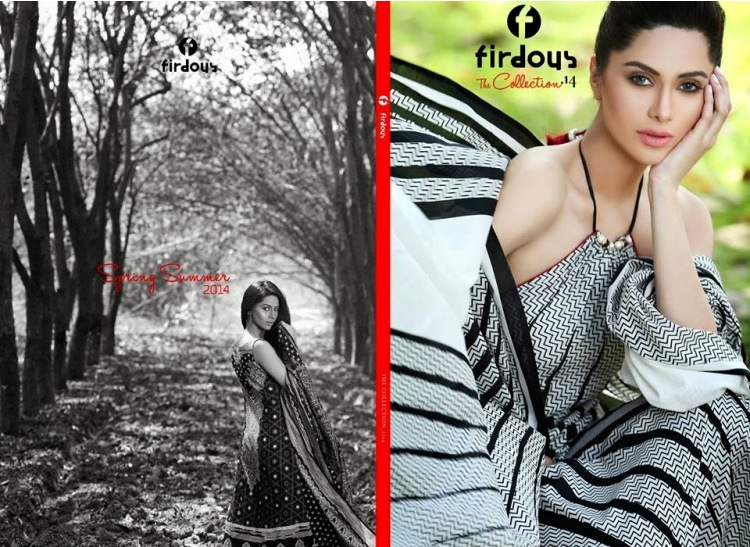

1/1 [==============================] - 0s
Classified as: [u'class=Photos']


In [23]:
try:
    img = random.choice(images)
    js = json.loads(analyze_image(img))['images']
    display(Image(img), embed=True)
    classifyImage(js, "/mfs/replicated/tivvit/externalImages/model3")
except Exception as e:
    print e

In [24]:
pprint(js)

[{u'path': u'/mfs/replicated/datasets/image-types/Mix/04520.JPEG',
  u'properties': {u'BR_128B_colCntUpTo80Perc': 0.796875,
                  u'BR_128B_colorCnt': 128,
                  u'BR_128B_top10%Sum': 0.0883144424131627,
                  u'BR_128B_topOne': 0.004372943327239488,
                  u'CB_128B_colCntUpTo80Perc': 0.7421875,
                  u'CB_128B_colorCnt': 128,
                  u'CB_128B_top10%Sum': 0.11588299817184644,
                  u'CB_128B_topOne': 0.01287263863497867,
                  u'CB_depth': 4742951671522260564,
                  u'CB_entropy': 0.0,
                  u'CB_kurtosis': 0.0,
                  u'CB_maxima': 45873760241640.83,
                  u'CB_mean': 2.7893011660661045e-06,
                  u'CB_minima': 894740574.1707237,
                  u'CB_skewness': 0.0,
                  u'CB_standard_deviation': 0.0,
                  u'CB_sum': 0.4522098194548996,
                  u'CB_sum_cubed': 6.67650012940293e-11,
             